## Bank Customer Segmentation for Loan Campaign

The task at hand is to create customer segments to maximize the effectiveness of the bank's personal loan campaign. The bank has key data as described here:

 * Experience: The work experience of the customer in years
 * Income: The estimated annual income of the customer (thousands of US dollars)
 * CCAvg: The average spending on credit cards per month (thousands of US dollars)
 * Mortgage: The value of the customer's house mortgage (if any)
 * Age: The age (in years) of the customer

### Understanding the Data

In [ ]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
bank0 = pd.read_csv("/content/drive/MyDrive/Marketing-Analytics/Data/Bank_Personal_Loan_Modelling-1.csv")
bank0.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [ ]:
bank0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal Loan       5000 non-null   int64  
 10  Securities Account  5000 non-null   int64  
 11  CD Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


In [ ]:
bank0.describe()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.104600,73.774200,93152.503000,2.396400,1.937938,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,1443.520003,11.463166,11.467954,46.033729,2121.852197,1.147663,1.747659,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,1.000000,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,2500.500000,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,3750.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


### Visualizations

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


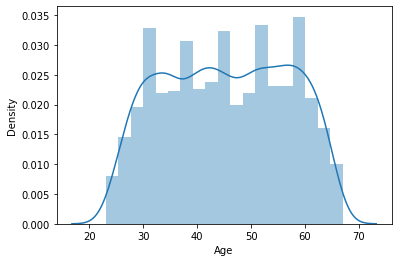

In [ ]:
# Distribution plot of Age

sns.distplot(bank0['Age'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


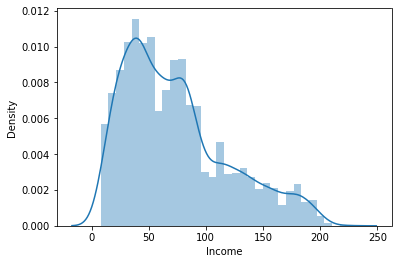

In [ ]:
# Distribution plot of Income

sns.distplot(bank0['Income'])

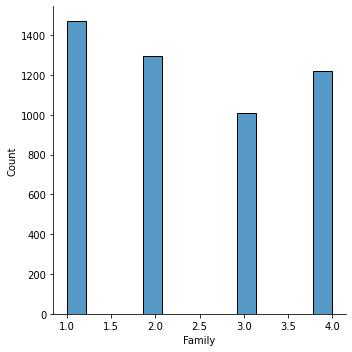

In [ ]:
# barplot plot of Family

sns.displot(bank0['Family'],kde=False)

In [ ]:
bank0['Personal Loan'].value_counts()

0    4520
1     480
Name: Personal Loan, dtype: int64

In [ ]:
# only about 10% of customers have a personal loan

480/(480+4520)

0.096

In [ ]:
# Count of those without a mortgage
bank0[bank0['Mortgage'] == 0].count()['Mortgage']

3462

In [ ]:
# Count of those with a mortgage
bank0[bank0['Mortgage'] > 0].count()['Mortgage']

1538

In [ ]:
# almost 31% of customers have a mortgage

1538/(1538+3462)

0.3076

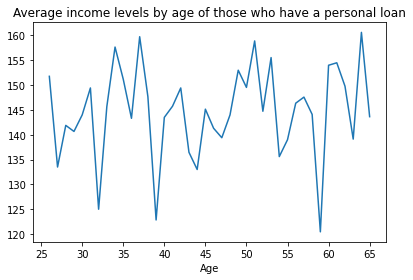

In [ ]:
# plot of average income by age of those with a personal loan

bank0[bank0['Personal Loan']>0].groupby('Age')['Income'].mean().plot()
plt.title('Average income levels by age of those who have a personal loan')
plt.tight_layout()

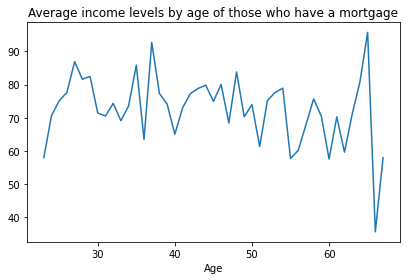

In [ ]:
# plot of average income by age of those with a mortgage

bank0[bank0['Mortgage']>0].groupby('Age')['Income'].mean().plot()
plt.title('Average income levels by age of those who have a mortgage')
plt.tight_layout()

In [ ]:
# The majority of those with a personal loan make a lot of $$

bank0.groupby('Personal Loan')['Income'].mean()

Personal Loan
0     66.237389
1    144.745833
Name: Income, dtype: float64

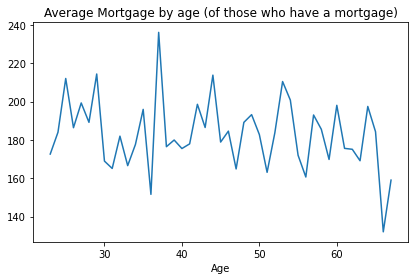

In [ ]:
# Plot of average mortgage by age

bank0[bank0['Mortgage']>0].groupby('Age')['Mortgage'].mean().plot()
plt.title('Average Mortgage by age (of those who have a mortgage)')
plt.tight_layout()

In [ ]:
# average income of those without a mortgage
bank0[bank0['Mortgage']==0]['Income'].mean()

73.88734835355287

In [ ]:
# average income of those with a mortgage
bank0[bank0['Mortgage']>0]['Income'].mean()

73.51950585175553

In [ ]:
# average income of those with a CC
bank0[bank0['CCAvg']>0]['Income'].mean()

73.6847159787495

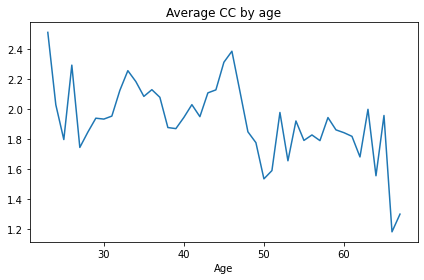

In [ ]:
# Plot of average CC by age

bank0.groupby('Age')['CCAvg'].mean().plot()
plt.title('Average CC by age')
plt.tight_layout()

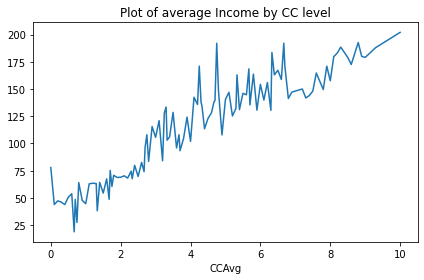

In [ ]:
# Plot of average Income by CC level

bank0.groupby('CCAvg')['Income'].mean().plot()
plt.title('Plot of average Income by CC level')
plt.tight_layout()

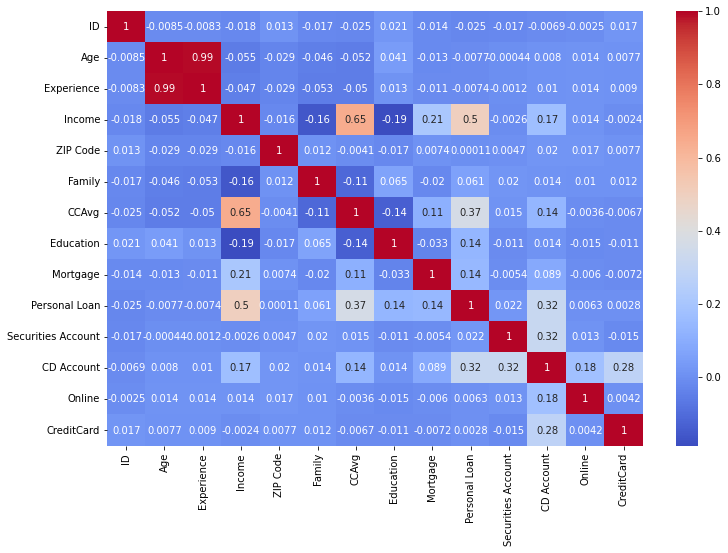

In [ ]:
# Heatmap; Income is well correlated with CCAvg and Personal Loan
plt.figure(figsize=(12,8))
sns.heatmap(bank0.corr(),cmap='coolwarm',annot=True)

### Segmentation with K-means clustering

K-means clustering is an algorithm that tries to find the best way of grouping data points into k different groups, where k is a parameter given to the algorithm.

The algorithm works iteratively to try to find the best grouping. There are two steps to this algorithm:
 1. The algorithm begins by randomly selecting k points in space to be the centroids of the clusters. Each data point is then assigned to the centroid that is closest to it.
 2. The centroids are updated to be the mean of all of the data points assigned to them. The data points are then reassigned to the centroid closest to them. This step is repeated until none of the data points change the centroid they are assigned to after the centroid is updated.

Calculating distance between customers

The geometric distance between entities in feature space is a natural way of measuring dissimilarity. On a two-dimensional scatter plot, the Euclidean distance between two customers (p and q) is just the distance between their points calculated as follows: $ d(p, q) = \sqrt{\sum (p_i - q_i)^2} $

In [ ]:
scaler = StandardScaler()

bank0[['Income_scaled', 'CCAvg_scaled']] = scaler.fit_transform(bank0[['Income', 'CCAvg']])

bank0[['Income_scaled', 'CCAvg_scaled']].describe()

,Income_scaled,CCAvg_scaled
count,5.000000e+03,5.000000e+03
mean,1.939449e-16,-2.078338e-17
std,1.000100e+00,1.000100e+00
min,-1.428969e+00,-1.108987e+00
25%,-7.554825e-01,-7.084116e-01
50%,-2.123482e-01,-2.506106e-01
75%,5.263146e-01,3.216407e-01
max,3.263712e+00,4.613525e+00


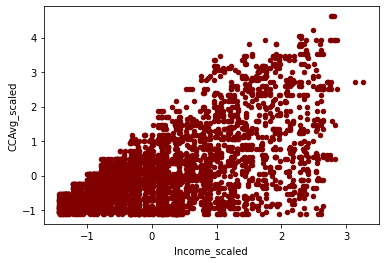

In [ ]:
bank0.plot.scatter(x='Income_scaled', y='CCAvg_scaled', color='maroon')
plt.show()

In [ ]:
model = KMeans(n_clusters=3, random_state=42)

cluster_cols = ['Income_scaled', 'CCAvg_scaled']
model.fit(bank0[cluster_cols])

bank0['Cluster'] = model.predict(bank0[cluster_cols])

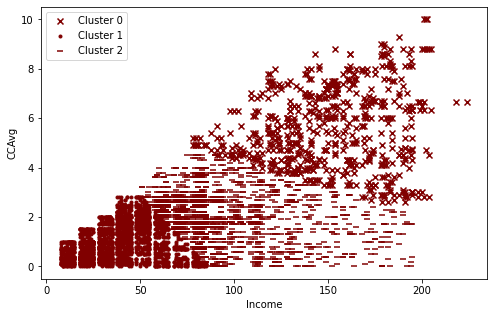

In [ ]:
markers = ['x', '.', '_']

plt.figure(figsize=[8,5])
for clust in range(3):
    temp = bank0[bank0.Cluster == clust]
    plt.scatter(temp.Income, temp.CCAvg, marker=markers[clust], color='maroon', label="Cluster "+str(clust) )
plt.xlabel('Income')
plt.ylabel('CCAvg')
plt.legend()
plt.show()

In [ ]:
bank0.groupby('Cluster')[['Income', 'CCAvg']].mean()

,Income,CCAvg
Cluster,,
0,150.390282,5.540345
1,39.135072,0.982417
2,96.142777,2.025165


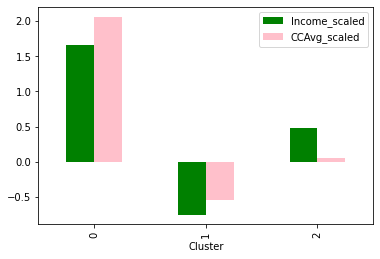

In [ ]:
bank0.groupby('Cluster')[['Income_scaled', 'CCAvg_scaled']].mean().plot.bar(color=['green','pink'])
plt.show()

In [ ]:
sel_cols = ['Income', 'CCAvg', 'Age', 'Mortgage', 'Family', 'CreditCard', 'Online', 'Personal Loan']
bank0.groupby('Cluster')[sel_cols].mean()

,Income,CCAvg,Age,Mortgage,Family,CreditCard,Online,Personal Loan
Cluster,,,,,,,,
0,150.390282,5.540345,43.924765,89.537618,2.017241,0.285266,0.605016,0.413793
1,39.135072,0.982417,45.797197,42.231218,2.513429,0.294667,0.592448,0.000000
2,96.142777,2.025165,45.184049,65.185165,2.363636,0.296152,0.600112,0.120468


## Bank Customer Segmentation with More Features

This cluster analysis will employ the additional features: Age, Experience, and Mortgage. 

In [ ]:
bank_scaled = bank0.copy()

cluster_cols = ['Income', 'CCAvg', 'Age', 'Experience', 'Mortgage']

bank_scaled[cluster_cols] = scaler.fit_transform\
                            (bank_scaled[cluster_cols])

In [ ]:
bank_scaled[cluster_cols].describe()

,Income,CCAvg,Age,Experience,Mortgage
count,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03
mean,1.939449e-16,-2.078338e-17,2.478018e-17,-1.693312e-16,2.810197e-16
std,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00
min,-1.428969e+00,-1.108987e+00,-1.948906e+00,-2.014911e+00,-5.555239e-01
25%,-7.554825e-01,-7.084116e-01,-9.019702e-01,-8.812043e-01,-5.555239e-01
50%,-2.123482e-01,-2.506106e-01,-2.952359e-02,-9.121982e-03,-5.555239e-01
75%,5.263146e-01,3.216407e-01,8.429230e-01,8.629604e-01,4.375576e-01
max,3.263712e+00,4.613525e+00,1.889859e+00,1.996667e+00,5.688108e+00


In [ ]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(bank_scaled[cluster_cols])

bank_scaled['Cluster'] = model.predict(bank_scaled[cluster_cols])

Principle component analysis (PCA) is a dimensionality reduction technique in which components are calculated in place of original values. PCA summarizes or combines correlated features together to decrease the overall number of features.

 * principal component equation: $ \text{maximize } \frac{1}{n} \sum^n_{i=1} (\sum^p_{j=1} \phi_jx_{ij})^2 $ 

In [ ]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
pca_res = pca.fit_transform(bank_scaled[cluster_cols])

bank_scaled['pc1'] = pca_res[:,0]
bank_scaled['pc2'] = pca_res[:,1]

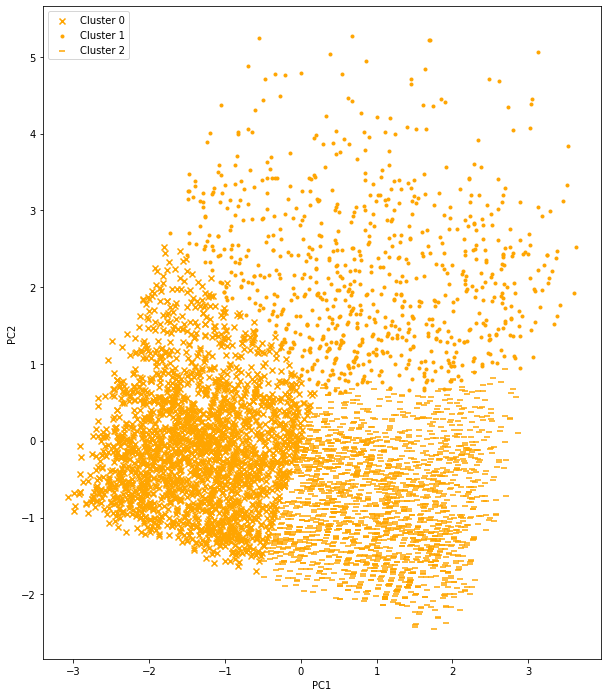

In [ ]:
markers = ['x', '.', '_']
plt.figure(figsize=[10,12])

for clust in range(3):
    temp = bank_scaled[bank_scaled.Cluster == clust]
    plt.scatter(temp.pc1, temp.pc2, marker=markers[clust], \
                label="Cluster "+str(clust), \
                color='orange')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

In [ ]:
bank0['Cluster'] = bank_scaled.Cluster
bank0.groupby('Cluster')[cluster_cols].mean()

,Income,CCAvg,Age,Experience,Mortgage
Cluster,,,,,
0,58.941774,1.367514,55.536044,30.233826,45.134935
1,147.650185,4.856403,43.672435,18.644005,116.279357
2,60.124322,1.382121,35.116428,9.873705,44.771584


In [ ]:
sel_cols = ['Income', 'CCAvg', 'Age', 'Experience', 'Mortgage', \
            'Family', 'CreditCard', 'Online', 'Personal Loan']

bank0.groupby('Cluster')[sel_cols].mean()

,Income,CCAvg,Age,Experience,Mortgage,Family,CreditCard,Online,Personal Loan
Cluster,,,,,,,,,
0,58.941774,1.367514,55.536044,30.233826,45.134935,2.397874,0.300370,0.604898,0.039741
1,147.650185,4.856403,43.672435,18.644005,116.279357,2.002472,0.299135,0.613103,0.398022
2,60.124322,1.382121,35.116428,9.873705,44.771584,2.552047,0.285150,0.581648,0.035520
